In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

/home/isidro/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/isidro/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/isidro/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/isidro/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dty

In [3]:
file = 'data/Hz31.txt'
data = pd.read_csv(file, names=['z', 'hz', 'err'], sep = " " )
data.head()

,z,hz,err
0,0.0700,69.0,19.6
1,0.0900,69.0,12.0
2,0.1200,68.6,26.2
3,0.1700,83.0,8.0
4,0.1791,75.0,4.0


In [4]:
data

,z,hz,err
0,0.0700,69.0,19.6
1,0.0900,69.0,12.0
2,0.1200,68.6,26.2
3,0.1700,83.0,8.0
4,0.1791,75.0,4.0
5,0.1993,75.0,5.0
6,0.2000,72.9,29.6
7,0.2700,77.0,14.0
8,0.2800,88.8,36.6
9,0.3519,83.0,14.0


Read the data for cosmic chronometers

In [5]:
randomize = np.random.permutation(len(data.values))
randomize


array([ 8, 18, 24, 23,  1, 29,  9, 21,  6,  2, 13, 20, 30, 11, 19, 14,  0,
       15,  5, 17, 16, 12, 28, 27,  7, 25,  3, 26, 22,  4, 10])

Let's prepare our input data. 

In [6]:
data = data.values[randomize]
data

array([[2.800e-01, 8.880e+01, 3.660e+01],
       [5.929e-01, 1.040e+02, 1.300e+01],
       [1.037e+00, 1.540e+02, 2.000e+01],
       [9.000e-01, 1.170e+02, 2.300e+01],
       [9.000e-02, 6.900e+01, 1.200e+01],
       [1.750e+00, 2.020e+02, 4.000e+01],
       [3.519e-01, 8.300e+01, 1.400e+01],
       [8.754e-01, 1.250e+02, 1.700e+01],
       [2.000e-01, 7.290e+01, 2.960e+01],
       [1.200e-01, 6.860e+01, 2.620e+01],
       [4.247e-01, 8.710e+01, 1.120e+01],
       [7.812e-01, 1.050e+02, 1.200e+01],
       [1.965e+00, 1.865e+02, 5.040e+01],
       [4.000e-01, 9.500e+01, 1.700e+01],
       [6.797e-01, 9.200e+01, 8.000e+00],
       [4.497e-01, 9.280e+01, 1.290e+01],
       [7.000e-02, 6.900e+01, 1.960e+01],
       [4.700e-01, 8.900e+01, 4.960e+01],
       [1.993e-01, 7.500e+01, 5.000e+00],
       [4.800e-01, 9.700e+01, 6.200e+01],
       [4.783e-01, 8.090e+01, 9.000e+00],
       [4.004e-01, 7.700e+01, 1.020e+01],
       [1.530e+00, 1.400e+02, 1.400e+01],
       [1.430e+00, 1.770e+02, 1.80

In [7]:
X = data[:,0]
y = data[:,1:]
X.shape, y.shape

((31,), (31, 2))

In [8]:
split = 0.8
ntrain = int(split * len(X))
indx = [ntrain]
X_train, X_test = np.split(X, indx)
y_train, y_test = np.split(y, indx)
X_train, y_train

(array([0.28  , 0.5929, 1.037 , 0.9   , 0.09  , 1.75  , 0.3519, 0.8754,
        0.2   , 0.12  , 0.4247, 0.7812, 1.965 , 0.4   , 0.6797, 0.4497,
        0.07  , 0.47  , 0.1993, 0.48  , 0.4783, 0.4004, 1.53  , 1.43  ]),
 array([[ 88.8,  36.6],
        [104. ,  13. ],
        [154. ,  20. ],
        [117. ,  23. ],
        [ 69. ,  12. ],
        [202. ,  40. ],
        [ 83. ,  14. ],
        [125. ,  17. ],
        [ 72.9,  29.6],
        [ 68.6,  26.2],
        [ 87.1,  11.2],
        [105. ,  12. ],
        [186.5,  50.4],
        [ 95. ,  17. ],
        [ 92. ,   8. ],
        [ 92.8,  12.9],
        [ 69. ,  19.6],
        [ 89. ,  49.6],
        [ 75. ,   5. ],
        [ 97. ,  62. ],
        [ 80.9,   9. ],
        [ 77. ,  10.2],
        [140. ,  14. ],
        [177. ,  18. ]]))

In [9]:
scaler = StandardScaler()
# scaler = MinMaxScaler(feature_range=(-1,1))
# # # fit scaler on data
scaler.fit(X.reshape(-1,1))
# # # apply transform
X = scaler.transform(X.reshape(-1,1))
# X

In [10]:
def autoencoder(input_z):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(200, activation='relu')(efirst)
    elast = Dense(200, activation='sigmoid')(ehidden)
    coded = Dense(10, activation='linear')(elast)
    #decoder 
    dfirst = Dense(200, activation='sigmoid')(coded)
    dhidden = Dense(200, activation='relu')(dfirst)
    dlast = Dense(100, activation='relu')(dhidden)
    decoded = Dense(2, activation='relu')(dlast)
    
    return decoded

In [11]:
batch_size = 2
epochs = 200
input_z = Input(shape = (1,))

In [12]:
autoencoder = Model(input_z, autoencoder(input_z))
autoencoder.compile(loss='mean_squared_error', optimizer = 'adam')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2010      
_________________________________________________________________
dense_4 (Dense)              (None, 200)               2200      
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200 

In [14]:
autoencoder_train = autoencoder.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test, y_test))

Train on 24 samples, validate on 7 samples
Epoch 1/200
24/24 [==============================] - 1s 24ms/sample - loss: 6162.1682 - val_loss: 5134.5648
Epoch 2/200
24/24 [==============================] - 0s 2ms/sample - loss: 4280.4761 - val_loss: 2469.7818
Epoch 3/200
24/24 [==============================] - 0s 2ms/sample - loss: 1450.8485 - val_loss: 876.3719
Epoch 4/200
24/24 [==============================] - 0s 2ms/sample - loss: 1133.5215 - val_loss: 746.6454
Epoch 5/200
24/24 [==============================] - 0s 2ms/sample - loss: 872.6038 - val_loss: 763.9587
Epoch 6/200
24/24 [==============================] - 0s 2ms/sample - loss: 785.9380 - val_loss: 703.4006
Epoch 7/200
24/24 [==============================] - 0s 2ms/sample - loss: 800.8358 - val_loss: 720.0403
Epoch 8/200
24/24 [==============================] - 0s 2ms/sample - loss: 743.6841 - val_loss: 644.0572
Epoch 9/200
24/24 [==============================] - 0s 2ms/sample - loss: 719.9650 - val_loss: 599.2730
Epoch

Epoch 78/200
24/24 [==============================] - 0s 2ms/sample - loss: 185.6299 - val_loss: 133.9262
Epoch 79/200
24/24 [==============================] - 0s 1ms/sample - loss: 208.6643 - val_loss: 202.2307
Epoch 80/200
24/24 [==============================] - 0s 2ms/sample - loss: 192.0956 - val_loss: 136.1784
Epoch 81/200
24/24 [==============================] - 0s 2ms/sample - loss: 179.5914 - val_loss: 169.3993
Epoch 82/200
24/24 [==============================] - 0s 2ms/sample - loss: 168.8703 - val_loss: 130.5747
Epoch 83/200
24/24 [==============================] - 0s 2ms/sample - loss: 160.7971 - val_loss: 168.6238
Epoch 84/200
24/24 [==============================] - 0s 1ms/sample - loss: 165.5853 - val_loss: 142.8381
Epoch 85/200
24/24 [==============================] - 0s 1ms/sample - loss: 169.4624 - val_loss: 152.0083
Epoch 86/200
24/24 [==============================] - 0s 1ms/sample - loss: 172.2627 - val_loss: 129.2392
Epoch 87/200
24/24 [==========================

Epoch 155/200
24/24 [==============================] - 0s 2ms/sample - loss: 161.3510 - val_loss: 154.8542
Epoch 156/200
24/24 [==============================] - 0s 1ms/sample - loss: 168.8462 - val_loss: 175.7146
Epoch 157/200
24/24 [==============================] - 0s 1ms/sample - loss: 163.9084 - val_loss: 144.5475
Epoch 158/200
24/24 [==============================] - 0s 2ms/sample - loss: 164.0072 - val_loss: 179.3427
Epoch 159/200
24/24 [==============================] - 0s 2ms/sample - loss: 189.0138 - val_loss: 181.7300
Epoch 160/200
24/24 [==============================] - 0s 2ms/sample - loss: 173.1565 - val_loss: 140.3821
Epoch 161/200
24/24 [==============================] - 0s 1ms/sample - loss: 174.2024 - val_loss: 181.1660
Epoch 162/200
24/24 [==============================] - 0s 2ms/sample - loss: 180.9506 - val_loss: 140.4528
Epoch 163/200
24/24 [==============================] - 0s 2ms/sample - loss: 172.4485 - val_loss: 154.8622
Epoch 164/200
24/24 [================

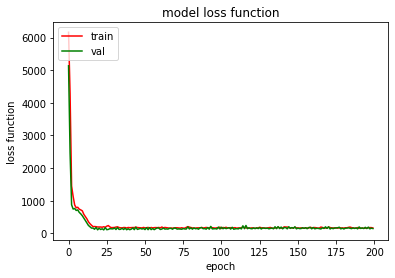

In [15]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
plt.title('model loss function')
plt.ylabel('loss function')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_ae.png")

In [16]:
#uncer net
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
unet

10.355354842517283

In [17]:
pred = autoencoder.predict(X_test)
pred

array([[ 83.51628 ,  20.808697],
       [159.96823 ,  26.45575 ],
       [ 73.46815 ,  19.924082],
       [163.8814  ,  27.067122],
       [119.34985 ,  21.041718],
       [ 74.26854 ,  20.00795 ],
       [ 87.44852 ,  21.028439]], dtype=float32)

In [47]:
r = np.random.uniform(0, 2.2, size=10000)
pred_random = autoencoder.predict(r)

(0.0, 2.2)

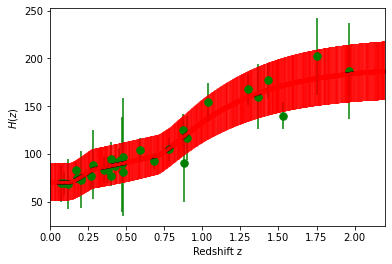

In [48]:
yupp = pred_random[:,0]+pred_random[:,1]
ylow = pred_random[:,0]-pred_random[:,1]
plt.errorbar(scaler.inverse_transform(X), y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations')
plt.errorbar(r, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.05)
plt.xlabel("Redshift z")
plt.ylabel("$H(z)$")
plt.xlim(0,2.2)

In [49]:
# Cosmological constants
Om = 0.27
# variance network


In [50]:
def Hlcdm(z, H0=73.24):
    return H0 * np.sqrt(Om*(1+z)**3 + 1 - Om)

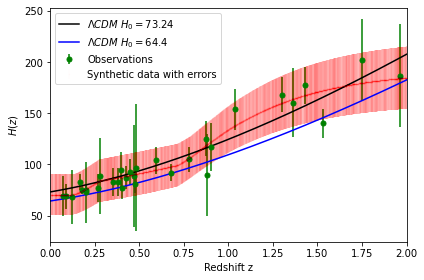

In [53]:
z = np.linspace(0, 2.0, 10000)
# plt.scatter(data[:, 0], data[:, 1], c='g')
yupp = pred_random[:,0]+pred_random[:,1]
ylow = pred_random[:,0]-pred_random[:,1]
plt.errorbar(scaler.inverse_transform(X), y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
plt.errorbar(r, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=2., label='Synthetic data with errors', alpha=0.01 )
plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
plt.plot(z, Hlcdm(z, H0=64.4), label='$\Lambda CDM$ $H_0 = 64.4$', c='b')
plt.xlabel("Redshift z")
plt.ylabel("$H(z)$")
plt.xlim(0,2.0)
plt.tight_layout()
plt.legend()

plt.savefig("SyntheticHD.png",dpi=800)

In [54]:
pred_random.shape, r.shape

((10000, 2), (10000,))

In [55]:
r_red = np.random.uniform(0, 2.2, size=100)
pred_red = autoencoder.predict(r_red)

mookHz = np.concatenate((r_red.reshape(-1,1), pred_red), axis=1)
np.savetxt("autoEncoderHz.dat",mookHz, delimiter=" ")

In [56]:
pred_red[:,1]

array([23.058758, 21.12719 , 21.148579, 30.585436, 26.966827, 29.554781,
       29.170177, 21.023064, 21.110271, 29.130022, 22.47209 , 20.957224,
       30.273556, 25.189379, 19.944485, 21.09986 , 22.289032, 23.184505,
       29.589191, 20.99125 , 30.64521 , 30.688158, 25.435625, 20.31892 ,
       20.894794, 19.614147, 21.116184, 25.563747, 22.419092, 29.321892,
       30.056288, 28.955517, 26.896576, 27.061142, 30.780832, 19.612553,
       21.165943, 20.920916, 21.180332, 30.514252, 30.781109, 20.92327 ,
       24.503105, 30.3479  , 28.6057  , 30.483847, 30.667133, 20.96448 ,
       22.377764, 23.023682, 21.029379, 29.985645, 20.521208, 29.751114,
       21.188646, 25.766626, 20.228231, 29.93409 , 27.360222, 26.837494,
       20.306084, 30.715546, 21.161201, 30.627737, 21.084309, 20.715574,
       20.322767, 24.347208, 20.953302, 25.75013 , 30.720558, 30.648996,
       26.582119, 20.491222, 21.067245, 29.04126 , 29.137161, 30.308304,
       25.839233, 19.612553, 21.16337 , 26.411308, 

In [57]:
error  = pred_red[:,1]**2
error

array([531.7063 , 446.35815, 447.2624 , 935.4689 , 727.2098 , 873.4851 ,
       850.89923, 441.9692 , 445.64355, 848.55817, 504.9948 , 439.20523,
       916.48816, 634.5048 , 397.78247, 445.20407, 496.80093, 537.5213 ,
       875.52026, 440.63254, 939.1289 , 941.76306, 646.971  , 412.85852,
       436.59244, 384.71478, 445.89325, 653.5052 , 502.6157 , 859.7733 ,
       903.38043, 838.42194, 723.4258 , 732.3054 , 947.45966, 384.65222,
       447.99716, 437.68472, 448.60648, 931.11957, 947.4767 , 437.7832 ,
       600.40216, 920.99506, 818.2861 , 929.2649 , 940.4731 , 439.5094 ,
       500.7643 , 530.0899 , 442.23477, 899.1389 , 421.11996, 885.1288 ,
       448.95874, 663.919  , 409.18134, 896.04974, 748.5817 , 720.2511 ,
       412.33704, 943.44476, 447.79645, 938.0583 , 444.54807, 429.135  ,
       413.01486, 592.78656, 439.0409 , 663.06915, 943.7527 , 939.36096,
       706.6091 , 419.8902 , 443.82883, 843.3948 , 848.9742 , 918.59326,
       667.66595, 384.65222, 447.88824, 697.5572 , 

In [58]:
diagcov = np.diag(error) #inverso
np.savetxt("autoEncoderHz_cov.dat", diagcov, delimiter= " ", header="#100 100")
np.shape(diagcov)

(100, 100)

In [59]:
dir_name = '/home/isidro/SimpleMC/chains/'
#/home/isidro/SimpleMC/SimpleMC/chains/mcmc_SN+HD+BBAO+Planck.txt
root1 = dir_name+'LCDM_phy_HD_nested_dynesty_multi'
root2 = dir_name+'LCDM_phy_HD_nested_dynesty_multi_new'

In [29]:
def Hzfunc(z, theta1):
    Omega_m, h = theta1
    Hz = 100*h*(Omega_m*(1+z)**3 +(1-Omega_m))**0.5
    return Hz

In [30]:
import numpy
import matplotlib.pyplot as plt
from fgivenx import plot_contours, samples_from_getdist_chains

In [31]:
samples, weights = samples_from_getdist_chains(['Om', 'h'], root1)
samples2, weights2 = samples_from_getdist_chains(['Om', 'h'], root2)

Text(0.5, 15.0, 'z')

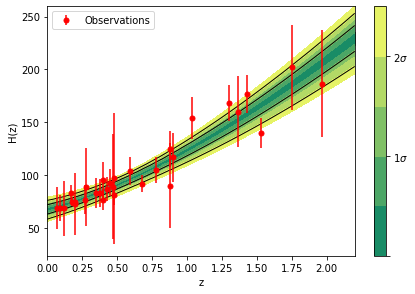

In [32]:
z = np.linspace(0, 2.2, 100)
cbar = plot_contours(Hzfunc, z, samples, weights=weights,
                             contour_line_levels=[1,2], linewidths=1,
                             colors=plt.get_cmap('summer'))


cbar = plt.colorbar(cbar, ticks=[0, 1, 2, 3])
        #cbar.set_ticklabels(['', r'$1\sigma$', r'$2\sigma$', r'$3\sigma$'])
cbar.set_ticklabels(['', '$1\sigma$', '$2\sigma$'])
        # plt.xscale('log')
    
plt.errorbar(scaler.inverse_transform(X), y[:,0], y[:,1], fmt='r.', 
             markersize=10, label='Observations')
# plt.errorbar(r, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=1, label='Synthetic data with errors', alpha=0.005, )

plt.tight_layout()
# plt.grid()
plt.legend(loc="upper left")
plt.ylabel('H(z)')
plt.xlabel('z')


Text(0.5, 15.0, 'z')

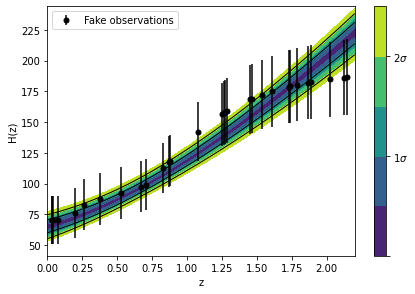

In [33]:
cbar2 = plot_contours(Hzfunc, z, samples2, weights=weights2,
                             contour_line_levels=[1,2], linewidths=1,
                             colors=plt.get_cmap('viridis'), 
                        rasterize_contours=True, smooth=0.1) 

cbar2 = plt.colorbar(cbar2, ticks=[0, 1, 2, 3])
        #cbar.set_ticklabels(['', r'$1\sigma$', r'$2\sigma$', r'$3\sigma$'])
cbar2.set_ticklabels(['', '$1\sigma$', '$2\sigma$'])
        # plt.xscale('log')
    
plt.errorbar(r_red[:30], pred_red[:30,0], pred_red[:30,1], fmt='k.', 
             markersize=10, label='Fake observations')
# plt.errorbar(r, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=1, label='Synthetic data with errors', alpha=0.005, )

plt.tight_layout()
# plt.grid()
plt.legend(loc="upper left")
plt.ylabel('H(z)')
plt.xlabel('z')


In [34]:
r_red[:20]

array([0.26571078, 0.37556587, 1.88954657, 0.66880925, 0.19687461,
       1.53746013, 1.86551847, 1.27093122, 1.73543733, 0.03640236,
       1.44874684, 2.02636481, 0.07883014, 0.53012124, 1.26201151,
       0.04283716, 1.08081033, 1.61068069, 1.46361785, 0.87508427])